In [2]:
import os
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\mbgdw\ML_project


In [4]:
train_dir = cwd + '/input/chest-xray-covid19-pneumonia/Data/train/*'
test_dir = cwd + '/input/chest-xray-covid19-pneumonia/Data/test/*'
train2_covid_dir = cwd + '/input/COVID-19_Radiography_Dataset/COVID'

In [5]:
SIZE = 140
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 140

In [6]:
categories_dict = {
  0: "PNEUMONIA",
  1: "NORMAL",
  2: "COVID19"
}

In [7]:
train_images = []
train_labels = [] 
label = 0

for directory_path in glob.glob(train_dir):
    print(directory_path)
    print(os.path.normpath(directory_path).split(os.path.sep)[-1])
    
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%200==0): print(counter,"images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        train_images.append(img)
        train_labels.append(label)
        counter+=1
        if(counter%1500==0): break
    
    print(counter,"images loaded")
    label +=1
    

C:\Users\mbgdw\ML_project/input/chest-xray-covid19-pneumonia/Data/train\COVID19
COVID19
200 images loaded
400 images loaded
461 images loaded
C:\Users\mbgdw\ML_project/input/chest-xray-covid19-pneumonia/Data/train\NORMAL
NORMAL
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1267 images loaded
C:\Users\mbgdw\ML_project/input/chest-xray-covid19-pneumonia/Data/train\PNEUMONIA
PNEUMONIA
200 images loaded
400 images loaded
600 images loaded
800 images loaded
1000 images loaded
1200 images loaded
1400 images loaded
1500 images loaded


In [8]:
#Importing the additional training dataset

print("additional",categories_dict[2],"data")    
addit_counter = 1
print(train2_covid_dir)
for img_path in glob.glob(os.path.join(train2_covid_dir, "*.png")):    
    if(addit_counter%200==0): print(addit_counter,"images loaded")
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, TARGET_SIZE)
    train_images.append(img)
    train_labels.append(2)
    addit_counter+=1
    if(addit_counter%1000==0): break
# print(addit_counter,"images loaded")

x_train = np.array(train_images)
y_train = to_categorical(train_labels, 3)

additional COVID19 data
C:\Users\mbgdw\ML_project/input/COVID-19_Radiography_Dataset/COVID
200 images loaded
400 images loaded
600 images loaded
800 images loaded


In [9]:
test_images = []
test_labels = []
label = 0

#importing the testing dataset

for directory_path in glob.glob(test_dir):
    print(directory_path)
    print(os.path.normpath(directory_path).split(os.path.sep)[-1])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(counter%100==0): print(counter, "images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        test_images.append(img)
        test_labels.append(label)
        counter+=1
    
    print(counter,"images loaded")
    label +=1

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, 3)

C:\Users\mbgdw\ML_project/input/chest-xray-covid19-pneumonia/Data/test\COVID19
COVID19
100 images loaded
117 images loaded
C:\Users\mbgdw\ML_project/input/chest-xray-covid19-pneumonia/Data/test\NORMAL
NORMAL
100 images loaded
200 images loaded
300 images loaded
318 images loaded
C:\Users\mbgdw\ML_project/input/chest-xray-covid19-pneumonia/Data/test\PNEUMONIA
PNEUMONIA
100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
856 images loaded


In [10]:
train_test_split(train_images, train_labels)
train_images, val_images, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.15, random_state=69)

In [11]:
print("train:",train_images.shape[0],", test:",test_images.shape[0],", val:",val_images.shape[0])

train: 3590 , test: 1288 , val: 634


In [12]:
def feature_extractor(images):
    image_dataset = pd.DataFrame()
    for image in images:   
        df = pd.DataFrame()
        
        #graycomatrix(image, distances, angles, levels=256, symmetric=False, normed=False)
        #distances - List of pixel pair distance offsets.
        #angles - List of pixel pair angles in radians.
        
        #5 configuration for the grey-level co-occurrence matrix calculation
        dists = [[1],[3],[5],[3],[3]]
        angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]
        
        for n ,(dist, angle) in enumerate(zip(dists, angles)):
        
            GLCM = graycomatrix(image, dist, angle)       
            GLCM_Energy = graycoprops(GLCM, 'energy')[0]
            df['Energy'+str(n)] = GLCM_Energy
            GLCM_corr = graycoprops(GLCM, 'correlation')[0]
            df['Corr'+str(n)] = GLCM_corr       
            GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = GLCM_diss       
            GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
            df['Homogen'+str(n)] = GLCM_hom       
            GLCM_contr = graycoprops(GLCM, 'contrast')[0]
            df['Contrast'+str(n)] = GLCM_contr

#         image_dataset = image_dataset.append(df)
        image_dataset = pd.concat([image_dataset, df])
        
    return image_dataset

In [13]:
train_extr_features = feature_extractor(train_images)

In [14]:
test_extr_features = feature_extractor(test_images)

In [15]:
val_extr_features = feature_extractor(val_images)

In [16]:
type(train_images)
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [17]:
pd.set_option("display.max_columns", None)
train_extr_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.028209,0.955000,8.812127,0.176118,311.779856,0.016006,0.875018,18.717310,0.088903,816.788321,0.012763,0.763210,26.675132,0.059078,1462.929312,0.020117,0.904030,15.720227,0.106036,645.937303,0.032123,0.938485,12.186757,0.159011,439.086340
0,0.079998,0.979443,6.743371,0.321765,207.770606,0.064439,0.906563,15.258811,0.208063,908.000730,0.054902,0.805269,22.657354,0.154579,1814.760635,0.063882,0.929664,13.914146,0.210995,685.983669,0.069975,0.955309,11.444004,0.231468,454.826486
0,0.017903,0.962809,7.519784,0.172182,186.576824,0.014258,0.902625,15.067518,0.095029,488.292127,0.012958,0.822634,21.364762,0.071786,891.145079,0.015126,0.919047,12.931317,0.104655,402.223377,0.017254,0.952084,9.346924,0.151224,238.287800
0,0.081102,0.950057,12.074101,0.168263,393.438232,0.058651,0.850387,23.408603,0.101929,1139.753337,0.042313,0.755004,31.294921,0.074284,1807.268254,0.067653,0.888099,20.070783,0.118117,861.985297,0.090619,0.923229,16.183003,0.163275,611.168926
0,0.044440,0.973079,7.750822,0.245726,252.776927,0.030600,0.906969,17.191554,0.138097,819.520959,0.022403,0.807032,25.396085,0.091961,1587.280317,0.035269,0.936050,14.663726,0.153173,582.204474,0.047656,0.966826,10.400834,0.200931,321.000521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.089717,0.992813,5.483607,0.348306,95.081346,0.075139,0.955203,14.753233,0.218489,585.188060,0.064173,0.896080,23.275132,0.171460,1340.536508,0.076897,0.975182,11.097931,0.243169,323.760292,0.077815,0.978790,9.534880,0.268230,284.080448
0,0.044430,0.956636,2.892549,0.403492,36.212179,0.031591,0.875657,5.499791,0.234266,104.620855,0.027809,0.847949,6.939683,0.178399,128.268360,0.032679,0.882635,5.126076,0.242771,96.830445,0.034822,0.913268,4.720594,0.258093,71.507873
0,0.096710,0.971221,9.434635,0.201268,235.127749,0.071396,0.883126,20.467153,0.130072,923.001043,0.047843,0.768858,29.649524,0.088954,1763.552698,0.083013,0.910371,18.109221,0.141772,716.337114,0.105910,0.934466,14.419812,0.187529,541.227216
0,0.022217,0.972214,6.160997,0.192608,148.858736,0.017283,0.931151,12.292179,0.109887,354.563608,0.015496,0.870615,17.739894,0.079858,639.959894,0.018239,0.951183,10.191871,0.125480,255.197543,0.023042,0.970566,7.498957,0.182991,161.258707


In [18]:
def build_cnn():
    model = keras.Sequential([
        keras.Input(shape=(140,140,1), name='Original_Images'),
        keras.layers.Conv2D(input_shape=(140,140,1), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv1'),
        keras.layers.Conv2D(input_shape=(130,130,32), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv2'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(58,58,32), filters=64, kernel_size=9, 
                            strides=1, activation='relu', name='Conv3'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(23,23,64), filters=128, kernel_size=8, 
                            strides=1, activation='relu', name='Conv4'),
        keras.layers.Conv2D(input_shape=(16,16,128), filters=256, kernel_size=9, 
                            strides=1, activation='relu', name='Conv5'),
        keras.layers.Conv2D(input_shape=(8,8,256), filters=256, kernel_size=8, 
                            strides=1, activation='relu', name='Conv6'),    

        keras.layers.Flatten(),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense')
    ])
    print(model.summary())
    return model

In [19]:
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=25, name='Extracted_Traditional_Features'),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense2')
    ])
    print(model.summary())
    return model

In [20]:
mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense1 (Dense)              (None, 8)                 208       
                                                                 
 Dense2 (Dense)              (None, 4)                 36        
                                                                 
Total params: 244
Trainable params: 244
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 130, 130, 32)      3904      
                                                                 
 Conv2 (Conv2D)              (None, 120, 120, 32)      123936    
                                                                 
 max_pooling2d (MaxPooling2D  (

In [21]:
opt = keras.optimizers.Adam(learning_rate=0.005)

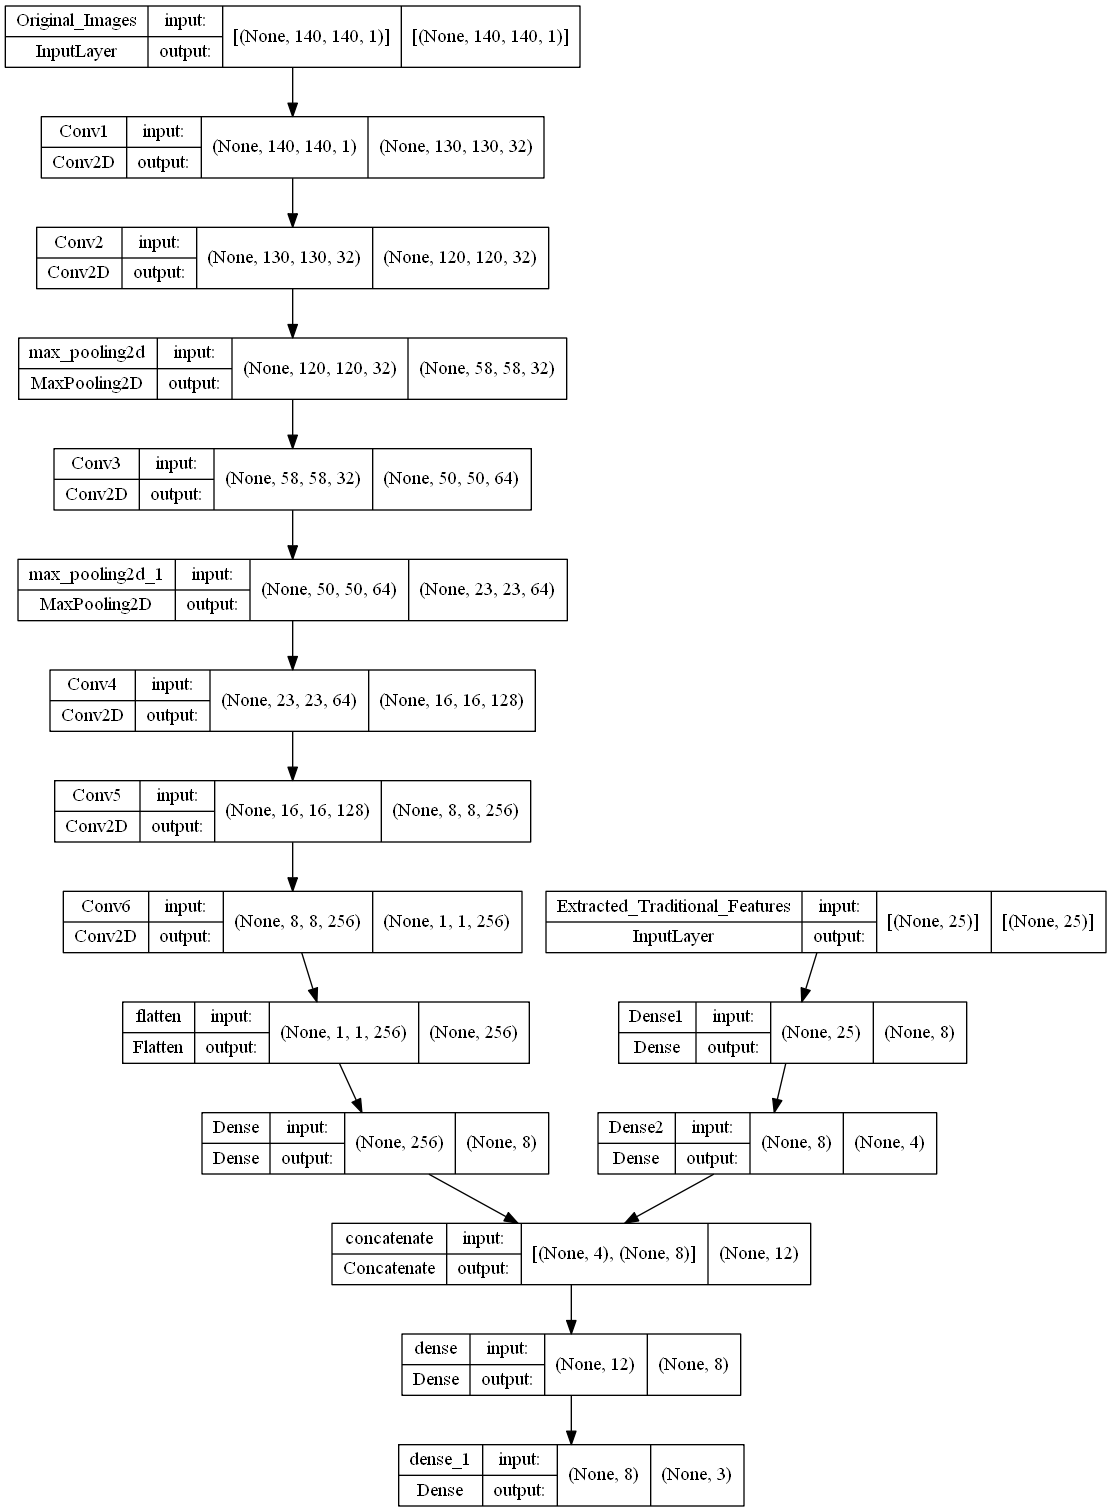

In [22]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[keras.metrics.CategoricalAccuracy()])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    )
]

In [24]:
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_extr_features, tf.expand_dims(train_images_norm, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labels)

dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TRAIN= train_images_norm.shape[0]//BATCH_SIZE
# fit model
history = model.fit(dataset, 
                    validation_data=([val_extr_features, tf.expand_dims(val_images_norm, axis=-1)], val_labels),
                    epochs = EPOCH_NUM, steps_per_epoch=STEP_SIZE_TRAIN, callbacks=cb)

Epoch 1/140
56/56 [==============================] - 16s 110ms/step - loss: 295.3810 - categorical_accuracy: 0.4799 - val_loss: 0.9714 - val_categorical_accuracy: 0.3249 - lr: 0.0050
Epoch 2/140
56/56 [==============================] - 6s 97ms/step - loss: 0.9191 - categorical_accuracy: 0.5800 - val_loss: 0.9114 - val_categorical_accuracy: 0.5599 - lr: 0.0050
Epoch 3/140
56/56 [==============================] - 6s 100ms/step - loss: 0.8799 - categorical_accuracy: 0.6171 - val_loss: 0.8775 - val_categorical_accuracy: 0.5536 - lr: 0.0050
Epoch 4/140
56/56 [==============================] - 6s 99ms/step - loss: 0.8319 - categorical_accuracy: 0.6427 - val_loss: 0.7926 - val_categorical_accuracy: 0.6625 - lr: 0.0050
Epoch 5/140
56/56 [==============================] - 5s 98ms/step - loss: 0.7705 - categorical_accuracy: 0.6826 - val_loss: 0.7566 - val_categorical_accuracy: 0.7192 - lr: 0.0050
Epoch 6/140
56/56 [==============================] - 5s 94ms/step - loss: 0.7441 - categorical_accur

56/56 [==============================] - 5s 97ms/step - loss: 0.5394 - categorical_accuracy: 0.8020 - val_loss: 0.5313 - val_categorical_accuracy: 0.8028 - lr: 0.0050
Epoch 47/140
56/56 [==============================] - 5s 96ms/step - loss: 0.5372 - categorical_accuracy: 0.8043 - val_loss: 0.5370 - val_categorical_accuracy: 0.8091 - lr: 0.0050
Epoch 48/140
56/56 [==============================] - 5s 96ms/step - loss: 0.5386 - categorical_accuracy: 0.8001 - val_loss: 0.5472 - val_categorical_accuracy: 0.8107 - lr: 0.0050
Epoch 49/140
56/56 [==============================] - 5s 98ms/step - loss: 0.5336 - categorical_accuracy: 0.8046 - val_loss: 0.5682 - val_categorical_accuracy: 0.7934 - lr: 0.0050
Epoch 50/140
56/56 [==============================] - 5s 96ms/step - loss: 0.5275 - categorical_accuracy: 0.8086 - val_loss: 0.5293 - val_categorical_accuracy: 0.7918 - lr: 0.0050
Epoch 51/140
56/56 [==============================] - 5s 96ms/step - loss: 0.5264 - categorical_accuracy: 0.8060 

56/56 [==============================] - 6s 98ms/step - loss: 0.4851 - categorical_accuracy: 0.8256 - val_loss: 0.5045 - val_categorical_accuracy: 0.8076 - lr: 5.0000e-04
Epoch 91/140
56/56 [==============================] - 5s 94ms/step - loss: 0.4841 - categorical_accuracy: 0.8250 - val_loss: 0.5039 - val_categorical_accuracy: 0.8091 - lr: 5.0000e-04
Epoch 92/140
56/56 [==============================] - ETA: 0s - loss: 0.4826 - categorical_accuracy: 0.8279
Epoch 92: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.
56/56 [==============================] - 5s 96ms/step - loss: 0.4826 - categorical_accuracy: 0.8279 - val_loss: 0.5049 - val_categorical_accuracy: 0.8076 - lr: 5.0000e-04
Epoch 93/140
56/56 [==============================] - 5s 98ms/step - loss: 0.4834 - categorical_accuracy: 0.8284 - val_loss: 0.4979 - val_categorical_accuracy: 0.8139 - lr: 5.0000e-05
Epoch 94/140
56/56 [==============================] - 5s 95ms/step - loss: 0.4799 - categorical_accuracy

56/56 [==============================] - 5s 95ms/step - loss: 0.4781 - categorical_accuracy: 0.8330 - val_loss: 0.4984 - val_categorical_accuracy: 0.8123 - lr: 5.0000e-07
Epoch 132/140
56/56 [==============================] - 5s 94ms/step - loss: 0.4799 - categorical_accuracy: 0.8321 - val_loss: 0.4984 - val_categorical_accuracy: 0.8123 - lr: 5.0000e-07
Epoch 133/140
56/56 [==============================] - 5s 94ms/step - loss: 0.4807 - categorical_accuracy: 0.8318 - val_loss: 0.4984 - val_categorical_accuracy: 0.8123 - lr: 5.0000e-07
Epoch 134/140
56/56 [==============================] - ETA: 0s - loss: 0.4834 - categorical_accuracy: 0.8296
Epoch 134: ReduceLROnPlateau reducing learning rate to 1e-07.
56/56 [==============================] - 5s 94ms/step - loss: 0.4834 - categorical_accuracy: 0.8296 - val_loss: 0.4984 - val_categorical_accuracy: 0.8123 - lr: 5.0000e-07
Epoch 135/140
56/56 [==============================] - 5s 96ms/step - loss: 0.4797 - categorical_accuracy: 0.8315 - v

In [25]:
model.save_weights('./kentang_net')

In [26]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_extr_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labelz = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labelz)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

20/20 [==============================] - 1s 33ms/step - loss: 0.5189 - categorical_accuracy: 0.7953
Test loss: 0.5189263224601746 / Test accuracy: 0.7953125238418579


In [27]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

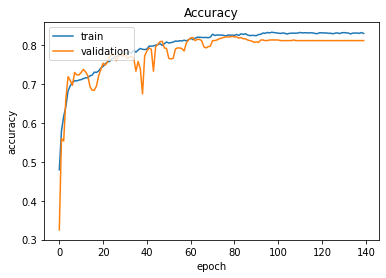

In [28]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

https://www.kaggle.com/code/kevinismail/pneumonia-covid19-classification-with-glcm-and-cnn/notebook